# Tutorial 1: Introduction to Singular Spectrum Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/vassal/blob/main/notebooks/01_basic_ssa_introduction.ipynb)

Singular Spectrum Analysis (SSA) is an effective nonparametric method for time series decomposition.

## Use Cases
SSA can be used to:
1. Separate deterministic components from noise within a time series;
2. Fill gaps in the time series using deterministic components;
3. Assess the significance of individual components.

This tutorial will primarily focus on separating deterministic components from noise (case 1).

## Drawbacks
Despite being a great decomposition tool, SSA has some drawbacks:
- SSA can be computationally intensive for large time series;
- SSA is an exploratory, empirical method that requires substantial user oversight;
- SSA is sensitive to the length of the time series as well as to outliers and skewness.

## Basic Principles
The primary concept in SSA involves creating a trajectory matrix using successive time series lags, followed by decomposition using Singular Value Decomposition (SVD). SVD is a linear matrix decomposition technique, similar to Principal Component Analysis (PCA), that extracts orthogonal components (vectors) ordered by descending variance (singular values).

Components with similar patterns can be grouped together to form coherent groups. Groups are then reconstructed into a matrix and converted back into a clean time series signal by averaging along the diagonals of the reconstructed trajectory matrix.

And there you have it! Let's dive into these concepts in more detail and see them in action!

## Import Modules


We import `matplotlib` for plotting, and from the `vassal` module, we import the 
`SingularSpectrumAnalysis` class, renaming it to `SSA` for brevity. We also import 
the `load_sst` function to access an included dataset of Sea Surface Temperature (SST).


In [1]:
#!pip install git+https://github.com/ADSCIAN/vassal.git # <-- Uncomment to install if needed
import matplotlib.pyplot as plt

from vassal import SingularSpectrumAnalysis as SSA
from vassal.datasets import load_sst


## Data

We access the documentation of the `load_sst` function with the built-in `help` method,
and we run the function to retrieve a time series `ts` as a [pandas.Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object. 
The data contain 504 monthly mean observations of sea surface temperature in °C from 1982-01-01 
to 2023-12-31.
We plot the data using the series [`plot`](https://pandas.pydata.org/docs/reference/api/pandas.Series.plot.html) method. 

Help on function load_sst in module vassal.datasets.data_loader:

load_sst() -> pandas.core.series.Series
    Load Sea Surface Temperature datasets return it as a pandas Series.
    
    The Sea Surface Temperature (SST) datasets contains monthly mean sea
    surface temperature in °C, from 1982-01-01 to 2023-12-31 globally between
    60° North and South, provided by the Climate Change Institute of University
    of Maine under a CC-BY license.
    
    Returns
    -------
    sst : pd.Series
        A pandas Series containing monthly mean total sunspot number from
        1749-01 to 2023-12, indexed using a pandas.DatetimeIndex.
    
    References
    ----------
    Climate Reanalyzer (n.d.). Monthly Sea Surface Temperature. Climate Change
    Institute, University of Maine. Retrieved June 06, 2024,
    from https://climatereanalyzer.org/
    
    Examples
    --------
    
    >>> from vassal.datasets import load_sst
    >>> sst = load_sst()
    >>> sst.head()
    Date
    1982-01-

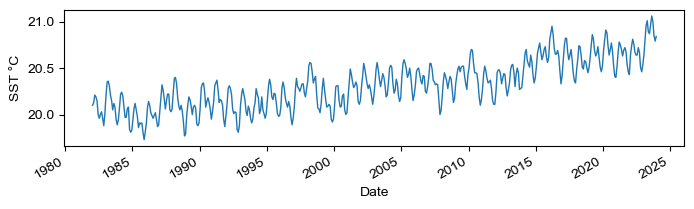

In [2]:
help(load_sst)
ts = load_sst()
ax = ts.plot(figsize=(8, 2), ylabel='SST °C', lw=1.)


## SSA Initialization

We now have the `ts` time series we aim to decompose. For assistance, we print the help of the `SSA` class,
and we instantiate the class with the `ts` time series object, keeping the other arguments as default.

After the initialization, the matrix to be decomposed has been constructed by default using the Broomhead &
King (1986) ('BK') approach relying on the default `window` parameter being approximately equal to the half-length 
(i.e., `len(ts)//2`) of the time series.

The 'BK' trajector matrix $\mathbf{X}$ is mathematically constructed based on a time series $X_t = \{x_1, x_2, \dots, x_N\}$ 
and the `window` parameter $L$ such that it has a dimension $L \times K$.
$$
\mathbf{X} = \begin{bmatrix} 
    x_1 & x_2 & x_3 & \dots & x_K \\
    x_2 & x_3 & x_4 & \dots & x_{K+1} \\
    x_3 & x_4 & x_5 & \dots & x_{K+2} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_L &  x_{L+1} & x_{L+2} & \dots & x_{N} 
    \end{bmatrix}
$$

After the initialization, we can access the trajectory matrix to be decomposed with the `svd_matrix` attributed.
We can also plot it with the `plot` method and the `kind` argument set to 'matrix'.




Singular Spectrum Analysis
--------------------------
# Parameters
kind: BK
window: 252
standardize: True
svd_solver: np_svd
status: None
n_components: None
groups: None

# Timeseries (Series, n=504, mean=20.32, std=0.26)
Date
1982-01-15    20.10
1982-02-15    20.13
1982-03-15    20.21
1982-04-15    20.19
1982-05-15    20.15
              ...  
2023-08-15    21.06
2023-09-15    21.00
2023-10-15    20.85
2023-11-15    20.79
2023-12-15    20.84
Length: 504, dtype: float64
        
Shape of the trajectory matrix (252, 253)


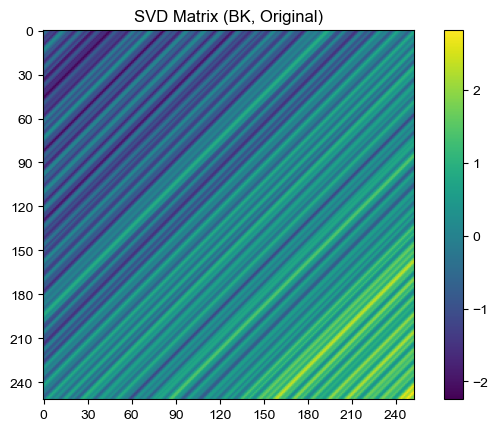

In [3]:
# help(SSA) # <- Uncomment to get help
ssa = SSA(ts)
print(ssa)
print('Shape of the trajectory matrix', ssa.svd_matrix.shape)
fig, ax = ssa.plot(kind='matrix')

You may have noticed that the values within the matrix ranges mainly between -2 and 2. 
By default, the matrix is constructed using the z-standardized timeseries resulting from the preprocessing.
You can view both series while calling the `plot` method with the `kind` parameter set to 'timeseries'.



SingularSpectrumAnalysis(
    timeseries=Date
1982-01-15    20.10
1982-02-15    20.13
1982-03-15    20.21
1982-04-15    20.19
1982-05-15    20.15
              ...  
2023-08-15    21.06
2023-09-15    21.00
2023-10-15    20.85
2023-11-15    20.79
2023-12-15    20.84
Length: 504, dtype: float64,
    window=252,
    svd_matrix='BK',
    svd_solver='np_svd',
    standardize=True
)
        

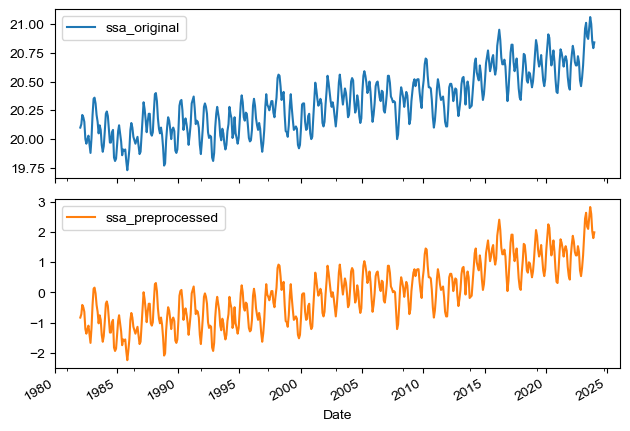

In [4]:
fig, axes = ssa.plot(kind='timeseries', subplots=True)
ssa

## SSA Decomposition

We can know decompose the matrix by calling the `decompose` method.

The Singular Value Decomposition (SVD) of a matrix $\mathbf{X}$ of shape $L \times K$ can be represented as:

$$
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
$$

where:

- $\mathbf{U} \in \mathbb{R}^{L \times L}$ is an orthogonal matrix whose columns are called the **left singular vectors** of $\mathbf{X}$.
- $\mathbf{\Sigma} \in \mathbb{R}^{L \times K}$ is a diagonal matrix containing the **singular values** of $\mathbf{X}$ along its diagonal.
- $\mathbf{V} \in \mathbb{R}^{K \times K}$ is an orthogonal matrix whose columns are called the **right singular vectors** of $\mathbf{X}$.
- $\mathbf{V}^T$ is the transpose of $\mathbf{V}$.

Alternatively, SVD can be described in the sum form as:

$$
\mathbf{X} = \sum_{i=1}^{r} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

where:

- $r$ is the **rank** of the matrix $\mathbf{X}$.
- $\sigma_i$ are the **singular values**, with $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_r > 0$.
- $\mathbf{u}_i \in \mathbb{R}^L$ and $\mathbf{v}_i \in \mathbb{R}^K$ are the **left** and **right singular vectors** corresponding to $\sigma_i$.

In this representation, SVD expresses the matrix $\mathbf{X}$ as a weighted sum of rank-1 matrices formed by the outer product of the left and right singular vectors.

We refer to $\mathbf{u}_i$, $\sigma_i$, $\mathbf{v}_i^T$ as the ith eigentriple. 

After calling the SSA `decompose` method, you can access the eigentriples.

In [5]:
ssa.decompose()
print(ssa)
u, s, vt = ssa.eigentriples
print('Eigentriple dimension:', [i.shape for i in ssa.eigentriples])


Singular Spectrum Analysis
--------------------------
# Parameters
kind: BK
window: 252
standardize: True
svd_solver: np_svd
status: Decomposed
n_components: 252
groups: None

# Timeseries (Series, n=504, mean=20.32, std=0.26)
Date
1982-01-15    20.10
1982-02-15    20.13
1982-03-15    20.21
1982-04-15    20.19
1982-05-15    20.15
              ...  
2023-08-15    21.06
2023-09-15    21.00
2023-10-15    20.85
2023-11-15    20.79
2023-12-15    20.84
Length: 504, dtype: float64
        
Eigentriple dimension: [(252, 252), (252,), (253, 253)]


## SSA Components Selection

The next step involves selecting a meaningful group of eigentriple components.

We will visualize the singular values and the left eigenvectors to make our selection.

Let us first look at the 50 first singular values with the `plot` method and the plot `kind` set to 'values'. 
These are in decreasing order in terms of captured variance, meaning the first components capture the most part of the signal dynamics.

 

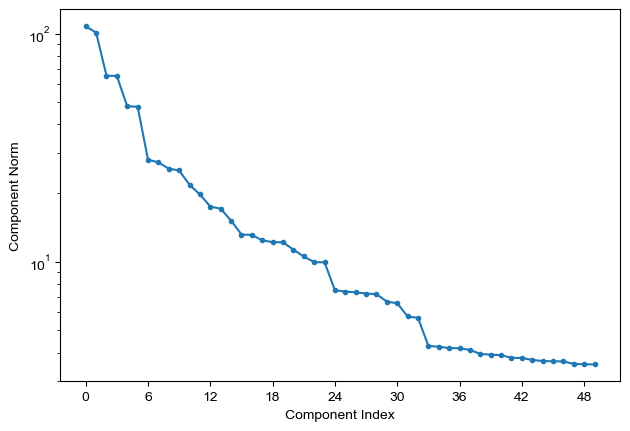

In [6]:
fig, ax = ssa.plot(kind='values', n_components=50, marker='.')

We can observe 
- a two-by-two component staircase pattern for the first 6 components;
- then a regular decrease in component norms until the 25th components
- another decrease until we reach another rupture point before the noise floor around the 33rd component. 

Note that the first component is indexed at 0. 

It is quite common that group of components belonging to the same plateau are grouped together. 
However, we can check if eigenvectors correlate and present similar patterns before defining groups for reconstruction.

In the next plot, we look at the weighted correlation matrix by setting the arguments `kind` to 'wcorr'.

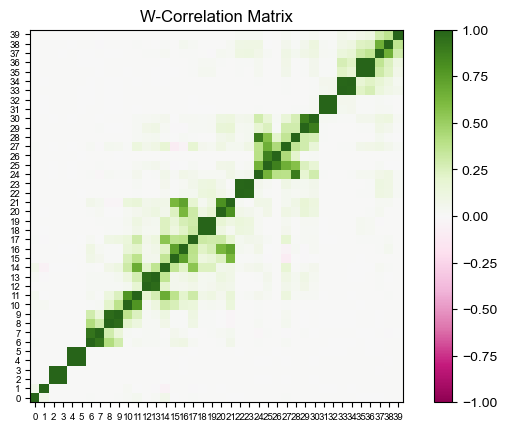

In [7]:
fig, ax = ssa.plot(kind='wcorr', n_components=40)

In this case, we see that component 0 and 1 do not correlate, likely because they capture the long-term trend. 
Group 2-3 and Group 4-5 are correlated and likely to represent cosine and sine signals associated with cycles in our signal. 

These first six components are well separated from the rest of the signal, where it is less structured and more challenging to isolate groups. 

Let us check our assumptions by directly looking at the eigenvectors with the `kind` parameters set to 'vectors'. 

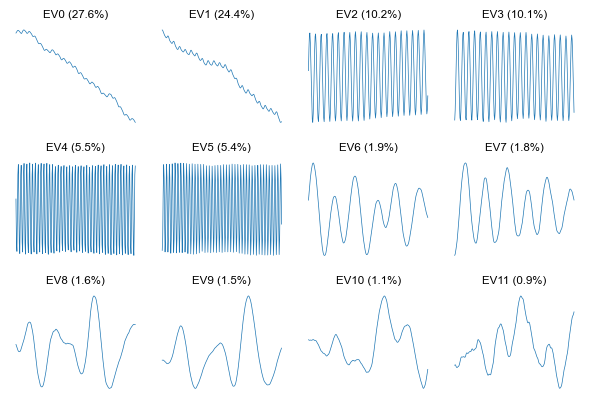

In [8]:
fig, ax = ssa.plot(kind='vectors', n_components=10, lw=.5)

The first two components indeed capture and trend in the component, although it is not extracted as clean as it could be and has a small harmonic behavior. 
The 2-3 component is a quasi-periodic cycle, as the group 4-5, yet, with a higher frequency. 

A last plotting option is to use the `kind` arguments set to 'paired' to see the suggessive vectors plotted against each other. 

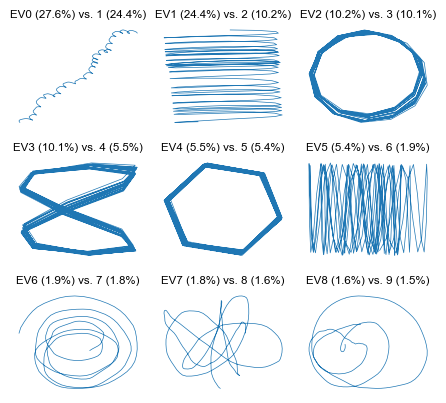

In [9]:
fig, ax = ssa.plot(kind='paired', n_components=10, lw=.5)

In this case, we see 
- the trendy behavior of components 0 and 1, 
- a dodecagon in eigenvectors that is representing the annual cycle (12-month period), and, 
- a hexagon for the group 4-5 that maps to a semi-annual cycle (6-month period). 

## SSA Reconstruction

For the reconstruction, a matrix can be reconstructed not for all, but for a selection of the components, given the SVD formula.

Given a group of indices $I = {2,3}$ for instance, we can reconstruct a matrix capturing the seasonal behavior with:
$$
\mathbf{X}_I = \sum_{i \in I} \sigma_i \mathbf{u}_i \mathbf{v}_i^T
$$

You can check it with the `plot` methods and the `kind` argument set to matrix, wich also enable to visualize reconstructed matrix based on selected indices. 


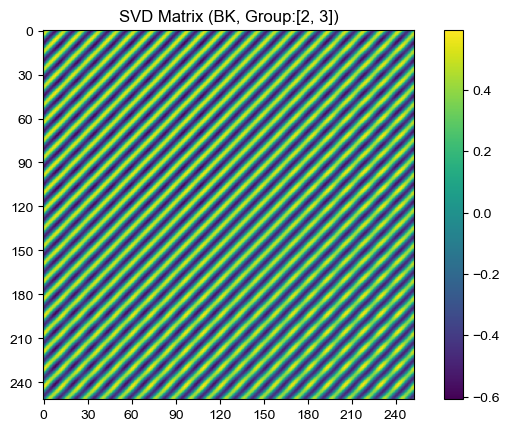

In [11]:
fig, ax = ssa.plot(kind='matrix', indices=[2, 3])

We indeed observe a perfectly regular pattern corresponding to the annual cycle. 

However, the matrix should still be transformed back into a timeseries component, which can be done by averaging the anti-diagonals of the reconstructed trajectory matrix. 

The `vassal` API let you recompose signals in a very flexible way using the getitem api with slicing. Hence, we can recover the annual cycle with: 

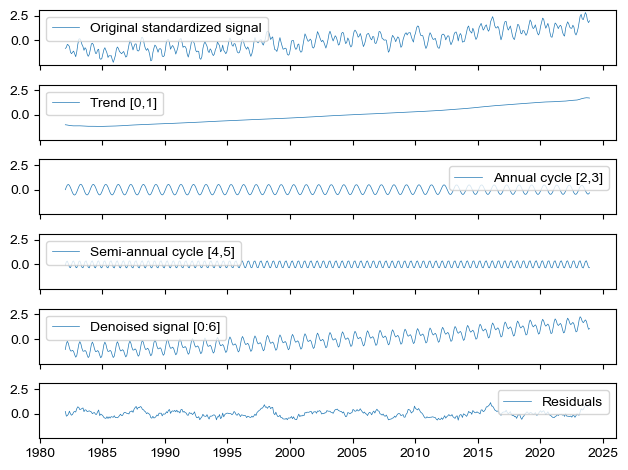

In [12]:
fig, axes = plt.subplots(6,1, sharex=True, sharey=True)
axes[0].plot(ssa._ix, ssa._timeseries_pp, label='Original standardized signal', lw=.5)
axes[1].plot(ssa[:2], label='Trend [0,1]', lw=.5)
axes[2].plot(ssa[2:4], label='Annual cycle [2,3]', lw=.5)
axes[3].plot(ssa[4:6], label='Semi-annual cycle [4,5]', lw=.5)
axes[4].plot(ssa[:6], label='Denoised signal [0:6]', lw=.5)
axes[5].plot(ssa._timeseries_pp - ssa[:6], label= 'Residuals', lw=.5)
for ax in axes:
    ax.legend()
fig.tight_layout()  

In the above example, we used `ssa._ix` to access the datetimeindex save in the `ssa` object and `ssa._timeseries_pp` to access directly to the z-standardized series.

We see that we have successfully isolated key components using SSA, that we have a clean denoised signal, and some residuals that still contain some low frequency
oscillations, possibly influenced by pluri-annual cycles such as the ENSO phenomenon. 

Alternatively, we could use a more formal approach using the `reconstruct` method while passing a dictionary with the desired groups.

In the following example, we reconstruct the same groups as before.

In [13]:
groups = {
    'Trend': [0, 1],
    '1Y_cycle': [2, 3],
    '6M_cycle': [4, 5],
    'Denoised_signal': [0, 1, 2, 3, 4, 5]
}
ssa.reconstruct(groups)

Reconstructed groups contain duplicate indices: [0, 1, 2, 3, 4, 5]



SingularSpectrumAnalysis(
    timeseries=Date
1982-01-15    20.10
1982-02-15    20.13
1982-03-15    20.21
1982-04-15    20.19
1982-05-15    20.15
              ...  
2023-08-15    21.06
2023-09-15    21.00
2023-10-15    20.85
2023-11-15    20.79
2023-12-15    20.84
Length: 504, dtype: float64,
    window=252,
    svd_matrix='BK',
    svd_solver='np_svd',
    standardize=True
)
        

We got a warning because we reconstructed different groups using multiple time the same indice, which means that we should not sum the signal we have reconstructed. 

We can view the signals using the `plot` method, with the `kind` parameter set to 'timeseries' and the keyword argument subplots.

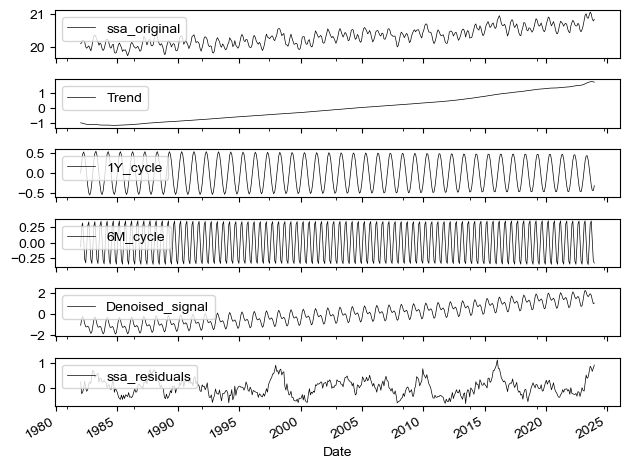

In [18]:
fig, axes = ssa.plot('timeseries', include=['ssa_original', 'Trend', '1Y_cycle', '6M_cycle', 'Denoised_signal', 'ssa_residuals'], subplots=True, color='k', lw=.5)
fig.tight_layout()

You can also rescale and recenter the decomposed signal to the original one, using these keywords: 

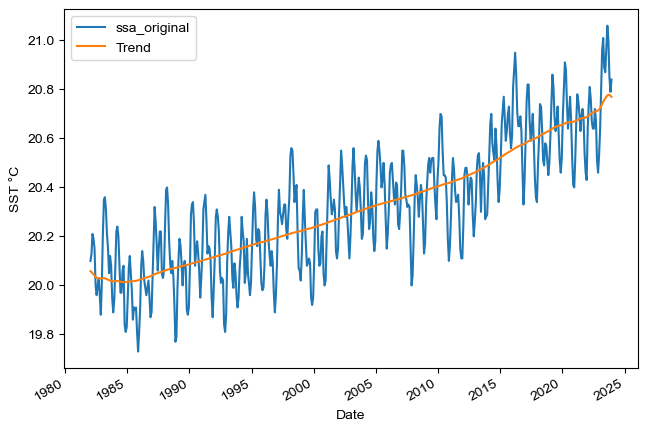

In [22]:
fig, ax = ssa.plot('timeseries', include=['ssa_original', 'Trend'], recenter=True, rescale=True)
_ = ax.set_ylabel('SST °C')

Using the `reconstruct` method also enabled the retrieval of components by their names. 

Date
1982-01-15   -0.993569
1982-02-15   -1.006196
1982-03-15   -1.024155
1982-04-15   -1.045457
1982-05-15   -1.065604
                ...   
2023-08-15    1.743738
2023-09-15    1.754162
2023-10-15    1.751717
2023-11-15    1.739077
2023-12-15    1.723549
Name: Trend, Length: 504, dtype: float64


<Axes: xlabel='Date'>

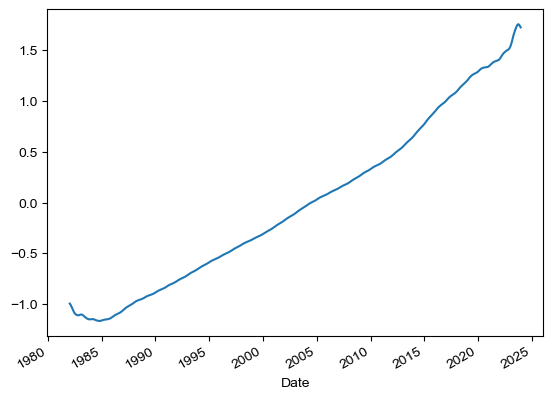

In [26]:
print(ssa['Trend'])
ssa['Trend'].plot()

If one need to rescale the reconstructed components manually, it is possible to access the original mean and standard deviation with the `mean_` and `std_` arguments.

In [27]:
ssa.mean_, ssa.std_

(20.318174603174604, 0.2620861084527186)

Finally, `vassal` makes it possible to export all reconstructed components using the `to_frame` method. The arguments can be used to include or exclude components, and specify whether recentering and rescaling are required. 

In [29]:
help(ssa.to_frame)
ssa.to_frame()

Help on method to_frame in module vassal.ssa:

to_frame(include: list[str] | None = None, exclude: list[str] | None = None, recenter: bool = False, rescale: bool = False) -> pandas.core.frame.DataFrame method of vassal.ssa.SingularSpectrumAnalysis instance
    Return signals as a pandas.DataFrame.
    
    Return `pandas.DataFrame` with all signals unless specified otherwise
    with the 'include' or 'exclude' parameters. If the
    `SingularSpectrumAnalysis` object was instantiated with and
    `pandas.Series` the returned DataFrame will have the same index.
    
    Parameters
    ----------
    include : list[str] | None, default=None
        Group names to include as column in the return `pandas.DataFrame`.
        If None, all groups will be included unless the 'exclude' parameter
        is specified.
    exclude : list[str] | None, default=None
        Group names to exclude as column in the return `pandas.DataFrame`.
        If None, all groups will be included unless the 'incl

,ssa_original,ssa_preprocessed,ssa_reconstructed,ssa_residuals,Trend,1Y_cycle,6M_cycle,Denoised_signal
Date,,,,,,,,
1982-01-15,20.10,-0.832454,-0.832454,0.234527,-0.993569,-0.002916,-0.070495,-1.066980
1982-02-15,20.13,-0.717988,-0.717988,-0.247002,-1.006196,0.277556,0.257654,-0.470985
1982-03-15,20.21,-0.412745,-0.412745,-0.187141,-1.024155,0.474260,0.324292,-0.225603
1982-04-15,20.19,-0.489055,-0.489055,-0.032882,-1.045457,0.531703,0.057580,-0.456173
1982-05-15,20.15,-0.641677,-0.641677,0.263030,-1.065604,0.436432,-0.275535,-0.904707
...,...,...,...,...,...,...,...,...
2023-08-15,21.06,2.830464,2.830464,0.878015,1.743738,-0.099800,0.308511,1.952449
2023-09-15,21.00,2.601532,2.601532,0.799230,1.754162,-0.310368,0.358509,1.802302
2023-10-15,20.85,2.029201,2.029201,0.664881,1.751717,-0.437595,0.050197,1.364320
